In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import circuit

from torchvision.transforms import Compose, CenterCrop, Grayscale, ToTensor, Lambda
from PIL import Image
from tqdm import tqdm

from scipy.stats import gennorm
from scipy.stats import norm

/mnt/sw/nix/store/gpkc8q6zjnp3n3h3w9hbmbj6gjbxs85w-python-3.10.10-view/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/mnt/sw/nix/store/6qvrglgqdpwhbw9zv2nh07fpd7a4wq31-py-torchvision-0.15.2/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
try:
    import plenoptic as po
except:
    !pip install git+https://github.com/LabForComputationalVision/plenoptic.git -qqq
    import plenoptic as po

In [25]:
# load an image from 01 to 23

filename = 'images/01.ras'

# common transforms

common_transforms = Compose([
    Grayscale(num_output_channels=1),
    CenterCrop((512, 512)),
])

with Image.open(filename) as img:
    img_transformed = common_transforms(img)
    img_tensor = ToTensor()(img_transformed)

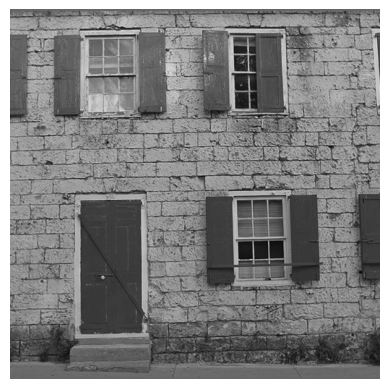

In [26]:
# display image

plt.imshow(img_tensor[0], cmap='gray')
plt.axis('off')
plt.show()

In [27]:
img_tensor.unsqueeze(0).shape

torch.Size([1, 1, 512, 512])

In [28]:
# extract coefficients

Spyr = po.simulate.SteerablePyramidFreq((512, 512), order=2, height=3, downsample=False, tight_frame=True)

po_objects = Spyr(img_tensor.unsqueeze(0))

wavelet_coefs = torch.flatten(po_objects[(0,0)][0,0]).numpy()

# Figure 1 experiments

In [29]:
# normalize variance of inputs

S = wavelet_coefs / np.std(wavelet_coefs)

# initialize circuit

rnn = circuit.circuit(s_dim=1, n_dim=1, g0=np.array([.2 + .05*np.random.rand(1)[0]]), theta0=np.array([2.2 + .1*np.random.rand(1)[0]]))

In [30]:
# learning parameters

batch_size, iters = 10, 10**4

# learning rates (chosen for 05.ras, for other images learning rates from the paper may be required)

lr_g, lr_theta = 5e-5, 5e-5

# run circuit

for _ in tqdm(range(iters)):
    batch = np.array([np.random.choice(S, batch_size)])
    rnn.fit_next(batch, lr_g=lr_g, lr_theta=lr_theta, lr_w=0)

100%|██████████| 10000/10000 [00:21<00:00, 468.26it/s]


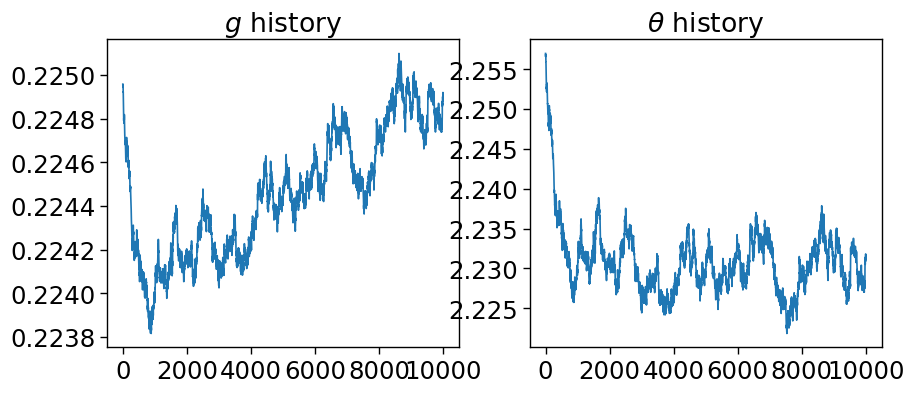

In [31]:
# plot parameters

with sns.plotting_context('paper', font_scale=2):

    fig, ax = plt.subplots(1, 2, figsize=(10,4))

    sns.lineplot(np.concatenate(rnn.g_hist), ax=ax[0]).set_title(r'$g$ history')
    sns.lineplot(np.concatenate(rnn.theta_hist), ax=ax[1]).set_title(r'$\theta$ history')

In [32]:
# compute responses

num_samples = len(S)
responses = np.zeros(num_samples)
for t in tqdm(range(num_samples)):
    responses[t] = rnn.response(S[t])[0]

100%|██████████| 262144/262144 [00:41<00:00, 6390.23it/s]


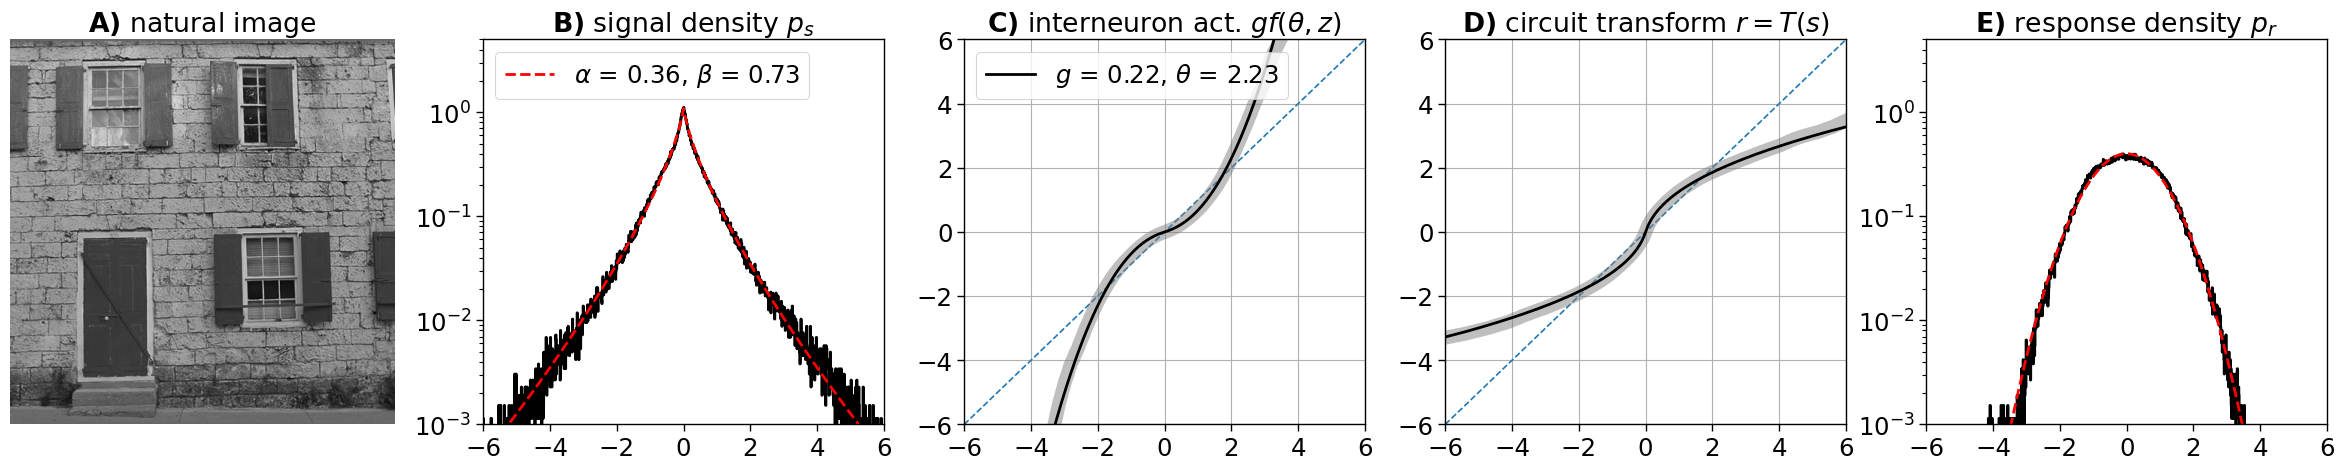

In [33]:
# figure 1 plot

x = np.linspace(-6, 6, 1000)

optimal_responses = np.random.randn(len(S))
optimal_sorted = np.sort(optimal_responses)

with sns.plotting_context('paper', font_scale=2):

    fix, ax = plt.subplots(1, 5, figsize=(30,5))

    ax[0].imshow(img_tensor[0], cmap='gray')
    ax[0].axis('off')

    params = gennorm.fit(S, loc=0)

    sns.histplot(S, binwidth=.01, lw=2, ax=ax[1], stat='density', color='black', element='step', fill=False)
    sns.lineplot(x=x, y=gennorm.pdf(x, beta=params[0], loc=params[1], scale=params[2]), lw=2, ax=ax[1], color='red', ls='--', label=r'$\alpha$' + f' = {round(params[2],2)}, ' + r'$\beta$' + f' = {round(params[0],2)}')
    ax[1].set(xlim=[-6,6],ylim=[1e-3,5], yscale='log', ylabel='')
    ax[1].legend(loc='upper left')

    inputs_sorted = np.sort(S)
    responses_sorted = np.sort(responses)

    interneuron = np.zeros(1000)
    for t in range(1000): interneuron[t] = rnn.interneuron_output(np.array([x[t]]))[0]

    sns.lineplot(x=x, y=x, ax=ax[2], ls='--')
    sns.lineplot(x=optimal_sorted[::100], y=inputs_sorted[::100], lw=10, ax=ax[2], color='gray', alpha=.5)
    sns.lineplot(x=x, y=interneuron, ax=ax[2], color='black', lw=2, label=r'$g$' + f' = {round(rnn.g[0],2)}, ' + r'$\theta$' + f' = {round(rnn.theta[0],2)}')
    ax[2].set(xlim=[-6,6],ylim=[-6,6])
    ax[2].grid()
    ax[2].legend(loc='upper left')

    sns.lineplot(x=x, y=x, ax=ax[3], ls='--')
    sns.lineplot(x=inputs_sorted[::100], y=optimal_sorted[::100], lw=10, ax=ax[3], color='gray', alpha=.5)
    sns.lineplot(x=inputs_sorted[::100], y=responses_sorted[::100], lw=2, ax=ax[3], color='black')
    ax[3].set(xlim=[-6,6],ylim=[-6,6])
    ax[3].grid()

    sns.histplot(responses, binwidth=.01, lw=2, ax=ax[4], stat='density', color='black', element='step', fill=False)
    sns.lineplot(x=x, y=norm.pdf(x), lw=2, ax=ax[4], color='red', ls='--')
    ax[4].set(xlim=[-6,6], ylim=[1e-3,5], yscale='log', ylabel='')

    ax[0].set(title=r'${\bf A)}$ natural image')
    ax[1].set(title=r'${\bf B)}$ signal density $p_s$')
    ax[2].set(title=r'${\bf C)}$ interneuron act. $gf(\theta,z)$')
    ax[3].set(title=r'${\bf D)}$ circuit transform $r=T(s)$')
    ax[4].set(title=r'${\bf E)}$ response density $p_r$')

# Figure 2 experiments

In [34]:
# Generate pairs of coefficients, choose offset

offset = 2

pairs_tensor = torch.zeros(2, (512-offset)*512)

for w in tqdm(range(512-offset)):
    for h in range(512):
        pairs_tensor[0, (512-offset)*h+w] = po_objects[(0, 0)][0,0][w, h]
        pairs_tensor[1, (512-offset)*h+w] = po_objects[(0, 0)][0,0][w + offset, h]

pairs = pairs_tensor.numpy()

100%|██████████| 510/510 [00:10<00:00, 50.74it/s]


In [35]:
# initialize circuit model

n_dim = 3

g0, theta0 = .2*np.ones(n_dim), 2.3*np.ones(n_dim)
rnn = circuit.circuit(s_dim=2, n_dim=n_dim, theta0=theta0, g0=g0)

S = pairs

S[0] = S[0] / np.std(pairs[0])
S[1] = S[1] / np.std(pairs[1])

In [ ]:
# learning parameters

batch_size, n_iters = 1, 10**5

# learning rates (chosen for 05.ras, for other images learning rates from the paper may be required)

lr_g = 1e-4
lr_theta = 1e-6
lr_w = 1e-4

# run circuit

for _ in tqdm(range(n_iters)):
    batch = S[:,np.random.choice(S.shape[1], size=batch_size, replace=False)]
    rnn.fit_next(batch, lr_g=lr_g, lr_theta=lr_theta, lr_w=lr_w)

 48%|████▊     | 47955/100000 [03:36<04:15, 203.93it/s]

In [ ]:
with sns.plotting_context('paper', font_scale=2):
    
    fig, ax = plt.subplots(1, 3, figsize=(18,5))

    for i in range(n_dim):
        sns.lineplot(rnn.g_hist[:,i], ax=ax[0]).set_title(r'$g$ history')
        sns.lineplot(rnn.theta_hist[:,i], ax=ax[1]).set_title(r'$\theta$ history')
        sns.lineplot(rnn.W_hist[:,i], ax=ax[2]).set_title(r'$W$ history')
        sns.lineplot(rnn.W_hist[:,-i], ax=ax[2])

In [ ]:
# compute responses 

responses = np.zeros(S.shape)

for t in tqdm(range(S.shape[1])):
    responses[:,t] = rnn.response(S[:,t])

In [ ]:
from sklearn.metrics import mutual_info_score
import matplotlib.lines as mlines

radii = np.linspace(0, 2.5, 5)
levels = 1 - np.exp(-radii**2/2)
t = np.linspace(0, 2*np.pi, 1000)

def compute_mutual_info(x, y, bin_width=0.5):
    
    return mutual_info_score(x // bin_width, y // bin_width)

def kde_plot(x, y, ax, levels=levels, ylabel=''):
    
    mutual_info = compute_mutual_info(x, y, bin_width=0.5)
    label = f'MI={np.format_float_scientific(mutual_info, precision=2, exp_digits=1)}'
    
    sns.kdeplot(x=x, y=y, ax=ax, levels=levels[:-1], linewidths=1, color='black')
    for r in radii[:-1]: ax.plot(r*np.cos(t), r*np.sin(t), alpha=.5, color='red', ls='--')
    black_line = mlines.Line2D([], [], color='black', label=label)
    ax.set(xlim=[-3,3], ylim=[-3,3], xticks=[], yticks=[], xlabel='', ylabel=ylabel)
    ax.legend(handles=[black_line], loc='upper left')

skip = 10

with sns.plotting_context('paper', font_scale=2):
    
    nrows, ncols = 1, 3
    fig, ax = plt.subplots(nrows, ncols, figsize=(4*ncols, 4*nrows), squeeze=False)
                        
    # whitened coefficients
    
    u, s, _ = np.linalg.svd(np.cov(S))
    ZCA = u@np.diag(1/np.sqrt(s))@u.T@pairs
    
    # plots
    
    kde_plot(S[0,::skip], S[1,::skip], ax[0, 0], ylabel=r'$d$' + f'={offset}')
    kde_plot(ZCA[0,::skip], ZCA[1,::skip], ax[0, 1])

    ax[0, 0].set(title=r'${\bf i)}$ wavelets')
    ax[0, 1].set(title=r'${\bf ii)}$ ZCA')
    ax[0, 2].set(title=r'${\bf iii)}$ responses ($K$' + f'={n_dim})')
    
    for i in range(n_dim): 
        ax[0, 2].plot(x, (rnn.W[1][i]/rnn.W[0][i])*x, lw=.5, color='gray', alpha=.4)
    kde_plot(responses[0,::skip], responses[1,::skip], ax=ax[0, 2])
            
plt.tight_layout()
plt.show()